In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot.plot

from audiot import *

# 2D Gaussians

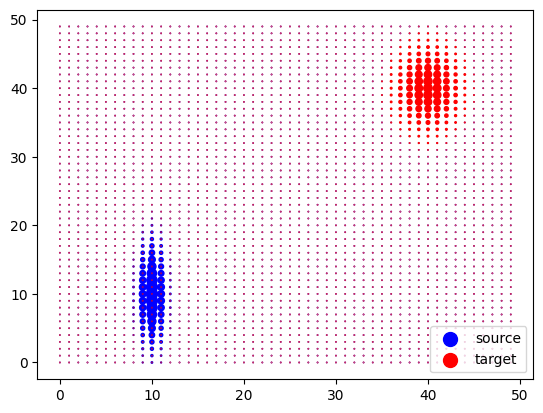

In [2]:
def gaussian_pdf_2d(x, m, s):
    num = (x - m).T.dot(np.linalg.inv(s))
    num = -0.5*num.dot(x - m)
    num = np.exp(num)
    
    den = 2 * np.pi * np.sqrt(np.linalg.det(s))

    return num / den

def make_2D_gauss(n_rows, n_cols, m, s, return_support=False):
    gaussian = np.zeros((n_rows * n_cols))
    support = np.zeros((n_rows * n_cols, 2))

    for i in range(n_rows):
        for j in range(n_cols):
            gaussian[i * n_rows + j] = gaussian_pdf_2d(np.array([i, j]), m, s)
            support[i * n_cols + j] = [i, j]

    if return_support:
        return gaussian / np.sum(gaussian), support
    
    return gaussian / np.sum(gaussian)


n_rows = 50
n_cols = 50

source_mu_r = 0.2
source_mu_c = 0.2
source_mu = np.array([source_mu_r * n_rows, source_mu_c * n_cols])
source_mu_s_r = np.array([0.01, 0])
source_mu_s_c = np.array([0, 0.25])
source_s = np.array([source_mu_s_r * n_rows, source_mu_s_c * n_cols])
source, support = make_2D_gauss(n_rows, n_cols, source_mu, source_s, return_support=True)

target_mu_r = 0.8
target_mu_c = 0.8
target_mu = np.array([target_mu_r * n_rows, target_mu_c * n_cols])
target_mu_s_r = np.array([0.05, 0])
target_mu_s_c = np.array([0, 0.15])
target_s = np.array([target_mu_s_r * n_rows, target_mu_s_c * n_cols])
target = make_2D_gauss(n_rows, n_cols, target_mu, target_s)

source_clipped = np.clip(source, 1e-4, None)
target_clipped = np.clip(target, 1e-4, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.legend(loc="lower right")

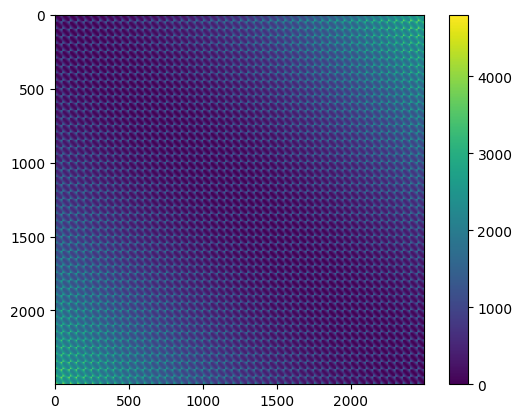

In [3]:
M = ot.dist(support, support)

plt.imshow(M)
plt.colorbar()

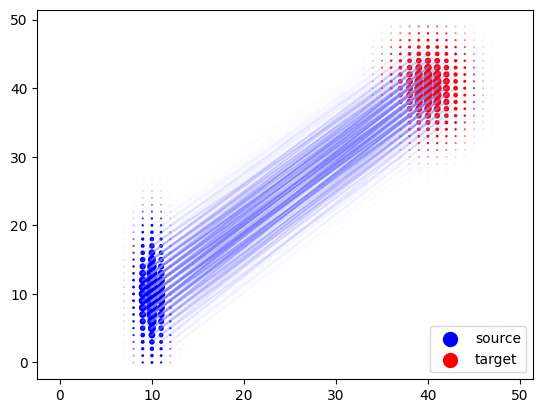

In [4]:
plan = ot.emd(source, target, M)

source_clipped = np.clip(source, 1e-8, None)
target_clipped = np.clip(target, 1e-8, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.legend(loc="lower right")

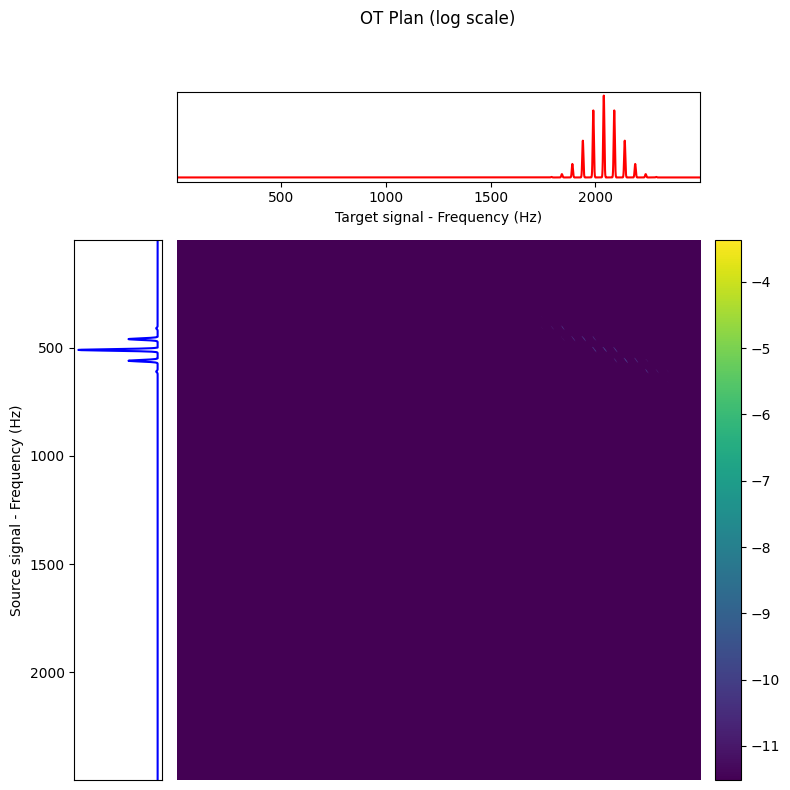

In [5]:
plot_plan_spectra(np.arange(len(support)), 
                  source, 
                  target, 
                  plan, 
                  source_freq_start=0, 
                  source_freq_end=-1, 
                  target_freq_start=0,
                  target_freq_end=-1)


In [6]:
def generate_interpolated_support(alpha, n_rows, support):
    n_cols = len(support) // n_rows
    interpolated_support = np.zeros((n_rows * n_cols, n_rows * n_cols, 2))

    for i in range(len(support)):
        for j in range(len(support)):
            interpolated_position = (1 - alpha) * support[i] + alpha * support[j]
            interpolated_support[i, j] = interpolated_position

    return interpolated_support

alpha = 0.5

interpolation_support = generate_interpolated_support(alpha, n_rows, support)
interpolation = plan

In [7]:
from collections import defaultdict

A = np.array([[[1, 2], [2, 1]], [[4, 5], [1, 2]]])
B = np.array([[4, 5], [1, 2]])

def add_values(plan, support):

    pos_dict = dict()

    for i in range(support.shape[0]):
        for j in range(support.shape[1]):
            pos = tuple(support[i, j])
            value = plan[i, j]
            if pos in pos_dict:
                pos_dict[pos] += value
            else:
                pos_dict[pos] = value

    new_plan = np.zeros_like(plan)
    for i in range(support.shape[0]):
        for j in range(support.shape[1]):
            pos = tuple(support[i, j])
            new_plan[i, j] = pos_dict[pos]

    return new_plan

added_plan = add_values(plan, interpolation_support)


        

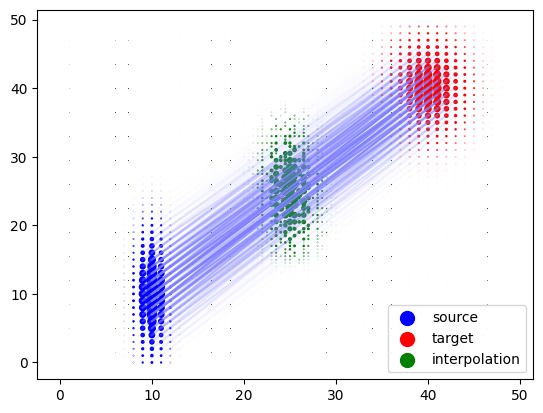

In [8]:
interpolation_clipped = np.clip(interpolation.flatten(), 1e-15, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
plt.scatter(interpolation_support[:, :, 0].flatten(), interpolation_support[:, :, 1].flatten(), c="g", s=interpolation_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.scatter([], [], c="green", label="interpolation", s=100)
plt.legend(loc="lower right")

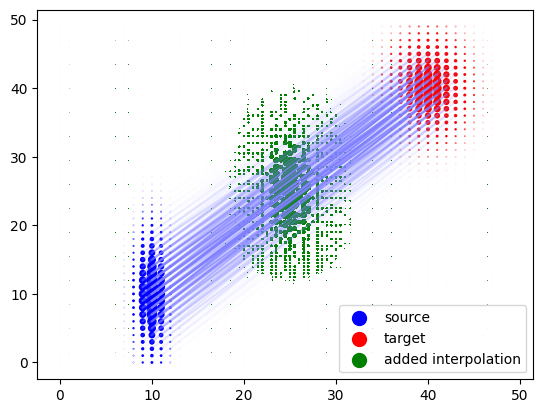

In [9]:
interpolation_added_clipped = np.clip(added_plan.flatten(), 1e-15, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
plt.scatter(interpolation_support[:, :, 0].flatten(), interpolation_support[:, :, 1].flatten(), c="g", s=interpolation_added_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.scatter([], [], c="green", label="added interpolation", s=100)
plt.legend(loc="lower right")

In [10]:
def adapt_interpolant(plan, interpolation_support, support): 
    # works well cause points are integers on a grid, would be too expensive to compute closer point for each point

    side = int(support.shape[0]**0.5)
    adapted_interpolation = np.zeros((side, side))

    for i in range(plan.shape[0]):
        for j in range(plan.shape[1]):
            new_point = np.round(interpolation_support[i, j]).astype(np.int64)
            adapted_interpolation[new_point[0], new_point[1]] += plan[i, j]

    return np.array(adapted_interpolation)

adapted_interpolation = adapt_interpolant(plan, interpolation_support, support)

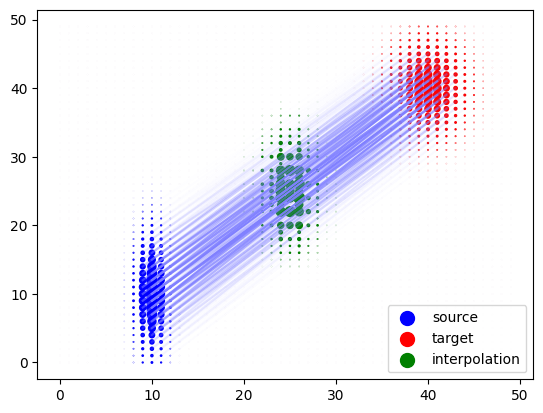

In [11]:
adapted_interpolation_clipped = np.clip(adapted_interpolation.flatten(), 1e-8, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="g", s=adapted_interpolation_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.scatter([], [], c="green", label="interpolation", s=100)
plt.legend(loc="lower right")